### 모델 변경
### outlier 제거는 없던 걸로

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import TensorBoard
import statsmodels.formula.api as smf
import shutil

In [2]:
%load_ext tensorboard

In [3]:
train_raw_dataset = pd.read_csv("/Users/jk/git/Study/Data/Dacon_dataset/dacon_basic_irisdataset/iris_train.csv")
test_raw_dataset = pd.read_csv("/Users/jk/git/Study/Data/Dacon_dataset/dacon_basic_irisdataset/iris_test.csv")
test_raw_dataset.shape

(75, 4)

In [4]:
test_raw_dataset.head()

,id,species,sepal length (cm),petal length (cm)
0,0,setosa,5.4,1.7
1,1,setosa,5.7,1.5
2,2,setosa,5.3,1.5
3,3,setosa,5.1,1.9
4,4,virginica,6.0,4.8


In [5]:
test_raw_dataset.species.value_counts()

setosa        35
versicolor    20
virginica     20
Name: species, dtype: int64

In [6]:
test_raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 75 non-null     int64  
 1   species            75 non-null     object 
 2   sepal length (cm)  75 non-null     float64
 3   petal length (cm)  75 non-null     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 2.5+ KB


In [7]:
test_raw_dataset.isnull().sum()

id                   0
species              0
sepal length (cm)    0
petal length (cm)    0
dtype: int64

In [8]:
train_raw_dataset = train_raw_dataset.drop("id", axis=1)
test_raw_dataset = test_raw_dataset.drop("id", axis=1)
train_raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            75 non-null     object 
 1   sepal length (cm)  75 non-null     float64
 2   petal length (cm)  75 non-null     float64
 3   sepal width (cm)   75 non-null     float64
 4   petal width (cm)   75 non-null     float64
dtypes: float64(4), object(1)
memory usage: 3.1+ KB


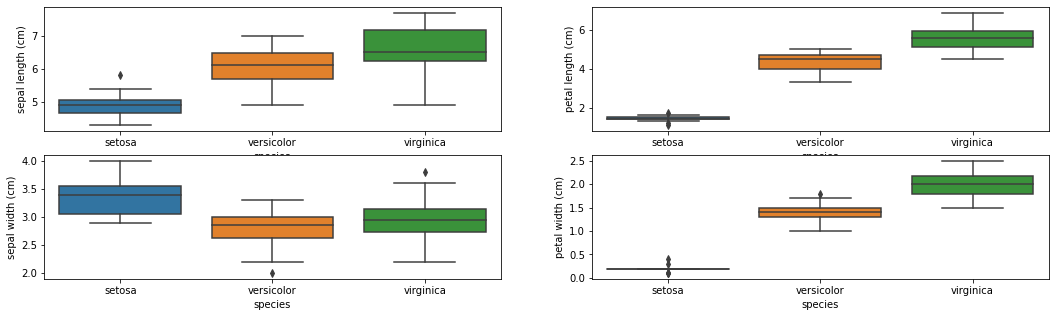

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(18, 5))
col = ['sepal length (cm)', 'petal length (cm)', 'sepal width (cm)',
       'petal width (cm)']

for idx, name in enumerate(col):
    i = idx // 2
    j = idx % 2
    sns.boxplot(x="species", y=name, data=train_raw_dataset, ax=ax[i][j])

# 실험해 본다면 sepal length 와 width의 outlier를 제거하는 것은 어떨까? - 오히려 더 떨어짐.

In [10]:
# 라벨 구분
LABEL = ['sepal width (cm)', 'petal width (cm)']
X_train = train_raw_dataset.copy()
X_train = X_train.drop(LABEL, axis=1)
y_train = train_raw_dataset[LABEL]
y_train.head()

# X_train, y_train = train_raw_dataset[0~1:1~2] 이런식으로 하는 방법은 없을까?


,sepal width (cm),petal width (cm)
0,2.9,0.2
1,3.2,1.5
2,2.8,1.8
3,3.6,2.5
4,3.0,0.2


In [11]:
# 범주형 데이터 species 처리
col = X_train["species"].unique()
species_col = {'setosa': 1, 'versicolor': 2, 'virginica': 3}
X_train["species"] = X_train.species.map(species_col)
test_raw_dataset["species"] = test_raw_dataset["species"].map(species_col)
X_train.head()
test_raw_dataset.head()

# map 말고 apply로 적용해보는 것은 어떨까?

,species,sepal length (cm),petal length (cm)
0,1,5.4,1.7
1,1,5.7,1.5
2,1,5.3,1.5
3,1,5.1,1.9
4,3,6.0,4.8


In [12]:
## input 데이터 만들기
# inputs = {col_name : keras.Input(name=col_name, shape=(), dtype="float32") for col_name in col_names}
input_dim = X_train.shape[1]
inputs = keras.layers.Input(shape=(input_dim, ))

# tf.dataset 형식으로 만들어보는 것은 어떨까?

In [69]:
# 모델 만들기
def build_model(inputs):
    layers = keras.layers.Dense(36, activation="tanh")(inputs)
    layers = keras.layers.Dense(18, activation="relu")(layers)
    layers = keras.layers.Dense(9, activation="tanh")(layers)
    layers = keras.layers.Dense(4, activation="relu")(layers)
    
    output_sw = keras.layers.Dense(1, name="prd_sepal_width")(layers)
    output_pw = keras.layers.Dense(1, name="prd_petal_width")(layers)
    outputs = [output_sw, output_pw]
    
    model = keras.models.Model(inputs, outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    # optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
    # optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
    # optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss="mae", metrics=["mae"])
    return model

# sub class 형식으로 만들어보는 것은 어떨까?

In [70]:
model = build_model(inputs)

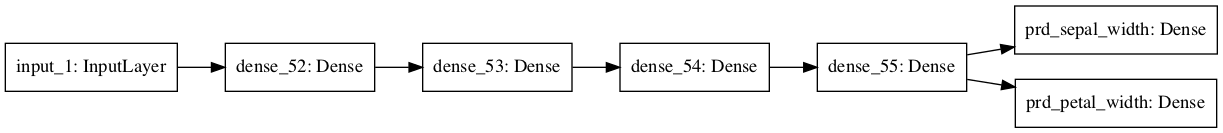

In [71]:
keras.utils.plot_model(model, show_shapes=False, rankdir="LR")

In [73]:
y_train.head()
OUTDIR = "./iris_train"
shutil.rmtree(path=OUTDIR, ignore_errors=True)

history = model.fit(x=X_train, y={"prd_sepal_width" : y_train["sepal width (cm)"], 
                                 "prd_petal_width" : y_train["petal width (cm)"]},
                   epochs=1000,
                   batch_size=16,
                   verbose=1,
                   callbacks=[TensorBoard(OUTDIR)])

Epoch 1/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3140 - prd_sepal_width_loss: 0.1929 - prd_petal_width_loss: 0.1211 - prd_sepal_width_mae: 0.1929 - prd_petal_width_mae: 0.1211
Epoch 2/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3074 - prd_sepal_width_loss: 0.1869 - prd_petal_width_loss: 0.1205 - prd_sepal_width_mae: 0.1869 - prd_petal_width_mae: 0.1205
Epoch 3/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3062 - prd_sepal_width_loss: 0.1858 - prd_petal_width_loss: 0.1205 - prd_sepal_width_mae: 0.1858 - prd_petal_width_mae: 0.1205
Epoch 4/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.3093 - prd_sepal_width_loss: 0.1880 - prd_petal_width_loss: 0.1213 - prd_sepal_width_mae: 0.1880 - prd_petal_width_mae: 0.1213
Epoch 5/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.3134 - prd_sepal_width_loss: 0.1913 - prd_petal_width_loss: 0.1221 - prd_sepal_width_mae: 0.1913 - prd_petal_width_mae: 0

5/5 [==============================] - 0s 2ms/step - loss: 0.3108 - prd_sepal_width_loss: 0.1878 - prd_petal_width_loss: 0.1231 - prd_sepal_width_mae: 0.1878 - prd_petal_width_mae: 0.1231
Epoch 42/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3094 - prd_sepal_width_loss: 0.1887 - prd_petal_width_loss: 0.1207 - prd_sepal_width_mae: 0.1887 - prd_petal_width_mae: 0.1207
Epoch 43/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.3079 - prd_sepal_width_loss: 0.1857 - prd_petal_width_loss: 0.1222 - prd_sepal_width_mae: 0.1857 - prd_petal_width_mae: 0.1222
Epoch 44/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3123 - prd_sepal_width_loss: 0.1894 - prd_petal_width_loss: 0.1229 - prd_sepal_width_mae: 0.1894 - prd_petal_width_mae: 0.1229
Epoch 45/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3188 - prd_sepal_width_loss: 0.1950 - prd_petal_width_loss: 0.1238 - prd_sepal_width_mae: 0.1950 - prd_petal_width_mae: 0.1238
Epoc

5/5 [==============================] - 0s 1ms/step - loss: 0.3091 - prd_sepal_width_loss: 0.1855 - prd_petal_width_loss: 0.1236 - prd_sepal_width_mae: 0.1855 - prd_petal_width_mae: 0.1236
Epoch 82/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3115 - prd_sepal_width_loss: 0.1899 - prd_petal_width_loss: 0.1216 - prd_sepal_width_mae: 0.1899 - prd_petal_width_mae: 0.1216
Epoch 83/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.3061 - prd_sepal_width_loss: 0.1837 - prd_petal_width_loss: 0.1223 - prd_sepal_width_mae: 0.1837 - prd_petal_width_mae: 0.1223
Epoch 84/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.3102 - prd_sepal_width_loss: 0.1869 - prd_petal_width_loss: 0.1233 - prd_sepal_width_mae: 0.1869 - prd_petal_width_mae: 0.1233
Epoch 85/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3030 - prd_sepal_width_loss: 0.1841 - prd_petal_width_loss: 0.1188 - prd_sepal_width_mae: 0.1841 - prd_petal_width_mae: 0.1188
Epoc

5/5 [==============================] - 0s 1ms/step - loss: 0.3053 - prd_sepal_width_loss: 0.1857 - prd_petal_width_loss: 0.1195 - prd_sepal_width_mae: 0.1857 - prd_petal_width_mae: 0.1195
Epoch 122/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3078 - prd_sepal_width_loss: 0.1851 - prd_petal_width_loss: 0.1226 - prd_sepal_width_mae: 0.1851 - prd_petal_width_mae: 0.1226
Epoch 123/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3045 - prd_sepal_width_loss: 0.1842 - prd_petal_width_loss: 0.1203 - prd_sepal_width_mae: 0.1842 - prd_petal_width_mae: 0.1203
Epoch 124/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3175 - prd_sepal_width_loss: 0.1959 - prd_petal_width_loss: 0.1216 - prd_sepal_width_mae: 0.1959 - prd_petal_width_mae: 0.1216
Epoch 125/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3108 - prd_sepal_width_loss: 0.1884 - prd_petal_width_loss: 0.1224 - prd_sepal_width_mae: 0.1884 - prd_petal_width_mae: 0.1224


5/5 [==============================] - 0s 2ms/step - loss: 0.3141 - prd_sepal_width_loss: 0.1906 - prd_petal_width_loss: 0.1234 - prd_sepal_width_mae: 0.1906 - prd_petal_width_mae: 0.1234
Epoch 162/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3233 - prd_sepal_width_loss: 0.2027 - prd_petal_width_loss: 0.1206 - prd_sepal_width_mae: 0.2027 - prd_petal_width_mae: 0.1206
Epoch 163/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3173 - prd_sepal_width_loss: 0.1933 - prd_petal_width_loss: 0.1239 - prd_sepal_width_mae: 0.1933 - prd_petal_width_mae: 0.1239
Epoch 164/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.3212 - prd_sepal_width_loss: 0.2007 - prd_petal_width_loss: 0.1205 - prd_sepal_width_mae: 0.2007 - prd_petal_width_mae: 0.1205
Epoch 165/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.3074 - prd_sepal_width_loss: 0.1878 - prd_petal_width_loss: 0.1195 - prd_sepal_width_mae: 0.1878 - prd_petal_width_mae: 0.1195


5/5 [==============================] - 0s 2ms/step - loss: 0.3241 - prd_sepal_width_loss: 0.1937 - prd_petal_width_loss: 0.1304 - prd_sepal_width_mae: 0.1937 - prd_petal_width_mae: 0.1304
Epoch 202/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3151 - prd_sepal_width_loss: 0.1913 - prd_petal_width_loss: 0.1237 - prd_sepal_width_mae: 0.1913 - prd_petal_width_mae: 0.1237
Epoch 203/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3055 - prd_sepal_width_loss: 0.1812 - prd_petal_width_loss: 0.1244 - prd_sepal_width_mae: 0.1812 - prd_petal_width_mae: 0.1244
Epoch 204/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3089 - prd_sepal_width_loss: 0.1865 - prd_petal_width_loss: 0.1225 - prd_sepal_width_mae: 0.1865 - prd_petal_width_mae: 0.1225
Epoch 205/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.3077 - prd_sepal_width_loss: 0.1857 - prd_petal_width_loss: 0.1220 - prd_sepal_width_mae: 0.1857 - prd_petal_width_mae: 0.1220


5/5 [==============================] - 0s 1ms/step - loss: 0.3040 - prd_sepal_width_loss: 0.1834 - prd_petal_width_loss: 0.1206 - prd_sepal_width_mae: 0.1834 - prd_petal_width_mae: 0.1206
Epoch 242/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3036 - prd_sepal_width_loss: 0.1838 - prd_petal_width_loss: 0.1197 - prd_sepal_width_mae: 0.1838 - prd_petal_width_mae: 0.1197
Epoch 243/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.3011 - prd_sepal_width_loss: 0.1809 - prd_petal_width_loss: 0.1201 - prd_sepal_width_mae: 0.1809 - prd_petal_width_mae: 0.1201
Epoch 244/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.3074 - prd_sepal_width_loss: 0.1838 - prd_petal_width_loss: 0.1236 - prd_sepal_width_mae: 0.1838 - prd_petal_width_mae: 0.1236
Epoch 245/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.3107 - prd_sepal_width_loss: 0.1831 - prd_petal_width_loss: 0.1276 - prd_sepal_width_mae: 0.1831 - prd_petal_width_mae: 0.1276


5/5 [==============================] - 0s 1ms/step - loss: 0.3136 - prd_sepal_width_loss: 0.1819 - prd_petal_width_loss: 0.1317 - prd_sepal_width_mae: 0.1819 - prd_petal_width_mae: 0.1317
Epoch 282/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.3076 - prd_sepal_width_loss: 0.1826 - prd_petal_width_loss: 0.1251 - prd_sepal_width_mae: 0.1826 - prd_petal_width_mae: 0.1251
Epoch 283/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3041 - prd_sepal_width_loss: 0.1836 - prd_petal_width_loss: 0.1205 - prd_sepal_width_mae: 0.1836 - prd_petal_width_mae: 0.1205
Epoch 284/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3151 - prd_sepal_width_loss: 0.1943 - prd_petal_width_loss: 0.1207 - prd_sepal_width_mae: 0.1943 - prd_petal_width_mae: 0.1207
Epoch 285/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.3090 - prd_sepal_width_loss: 0.1894 - prd_petal_width_loss: 0.1197 - prd_sepal_width_mae: 0.1894 - prd_petal_width_mae: 0.1197


5/5 [==============================] - 0s 1ms/step - loss: 0.3089 - prd_sepal_width_loss: 0.1829 - prd_petal_width_loss: 0.1260 - prd_sepal_width_mae: 0.1829 - prd_petal_width_mae: 0.1260
Epoch 322/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3010 - prd_sepal_width_loss: 0.1810 - prd_petal_width_loss: 0.1201 - prd_sepal_width_mae: 0.1810 - prd_petal_width_mae: 0.1201
Epoch 323/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3027 - prd_sepal_width_loss: 0.1849 - prd_petal_width_loss: 0.1178 - prd_sepal_width_mae: 0.1849 - prd_petal_width_mae: 0.1178
Epoch 324/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3015 - prd_sepal_width_loss: 0.1808 - prd_petal_width_loss: 0.1207 - prd_sepal_width_mae: 0.1808 - prd_petal_width_mae: 0.1207
Epoch 325/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.3006 - prd_sepal_width_loss: 0.1804 - prd_petal_width_loss: 0.1202 - prd_sepal_width_mae: 0.1804 - prd_petal_width_mae: 0.1202


5/5 [==============================] - 0s 2ms/step - loss: 0.3158 - prd_sepal_width_loss: 0.1864 - prd_petal_width_loss: 0.1293 - prd_sepal_width_mae: 0.1864 - prd_petal_width_mae: 0.1293
Epoch 362/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3083 - prd_sepal_width_loss: 0.1837 - prd_petal_width_loss: 0.1245 - prd_sepal_width_mae: 0.1837 - prd_petal_width_mae: 0.1245
Epoch 363/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3111 - prd_sepal_width_loss: 0.1830 - prd_petal_width_loss: 0.1281 - prd_sepal_width_mae: 0.1830 - prd_petal_width_mae: 0.1281
Epoch 364/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3079 - prd_sepal_width_loss: 0.1794 - prd_petal_width_loss: 0.1286 - prd_sepal_width_mae: 0.1794 - prd_petal_width_mae: 0.1286
Epoch 365/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.3067 - prd_sepal_width_loss: 0.1823 - prd_petal_width_loss: 0.1244 - prd_sepal_width_mae: 0.1823 - prd_petal_width_mae: 0.1244


5/5 [==============================] - 0s 1ms/step - loss: 0.3014 - prd_sepal_width_loss: 0.1804 - prd_petal_width_loss: 0.1211 - prd_sepal_width_mae: 0.1804 - prd_petal_width_mae: 0.1211
Epoch 402/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3007 - prd_sepal_width_loss: 0.1805 - prd_petal_width_loss: 0.1201 - prd_sepal_width_mae: 0.1805 - prd_petal_width_mae: 0.1201
Epoch 403/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3176 - prd_sepal_width_loss: 0.1956 - prd_petal_width_loss: 0.1220 - prd_sepal_width_mae: 0.1956 - prd_petal_width_mae: 0.1220
Epoch 404/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3187 - prd_sepal_width_loss: 0.1952 - prd_petal_width_loss: 0.1235 - prd_sepal_width_mae: 0.1952 - prd_petal_width_mae: 0.1235
Epoch 405/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3132 - prd_sepal_width_loss: 0.1929 - prd_petal_width_loss: 0.1203 - prd_sepal_width_mae: 0.1929 - prd_petal_width_mae: 0.1203


5/5 [==============================] - 0s 2ms/step - loss: 0.2988 - prd_sepal_width_loss: 0.1801 - prd_petal_width_loss: 0.1187 - prd_sepal_width_mae: 0.1801 - prd_petal_width_mae: 0.1187
Epoch 442/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2983 - prd_sepal_width_loss: 0.1784 - prd_petal_width_loss: 0.1198 - prd_sepal_width_mae: 0.1784 - prd_petal_width_mae: 0.1198
Epoch 443/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2984 - prd_sepal_width_loss: 0.1782 - prd_petal_width_loss: 0.1202 - prd_sepal_width_mae: 0.1782 - prd_petal_width_mae: 0.1202
Epoch 444/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3007 - prd_sepal_width_loss: 0.1809 - prd_petal_width_loss: 0.1198 - prd_sepal_width_mae: 0.1809 - prd_petal_width_mae: 0.1198
Epoch 445/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.3038 - prd_sepal_width_loss: 0.1851 - prd_petal_width_loss: 0.1187 - prd_sepal_width_mae: 0.1851 - prd_petal_width_mae: 0.1187


5/5 [==============================] - 0s 1ms/step - loss: 0.3038 - prd_sepal_width_loss: 0.1818 - prd_petal_width_loss: 0.1220 - prd_sepal_width_mae: 0.1818 - prd_petal_width_mae: 0.1220
Epoch 482/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.3013 - prd_sepal_width_loss: 0.1805 - prd_petal_width_loss: 0.1209 - prd_sepal_width_mae: 0.1805 - prd_petal_width_mae: 0.1209
Epoch 483/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.3015 - prd_sepal_width_loss: 0.1803 - prd_petal_width_loss: 0.1212 - prd_sepal_width_mae: 0.1803 - prd_petal_width_mae: 0.1212
Epoch 484/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3016 - prd_sepal_width_loss: 0.1808 - prd_petal_width_loss: 0.1208 - prd_sepal_width_mae: 0.1808 - prd_petal_width_mae: 0.1208
Epoch 485/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3003 - prd_sepal_width_loss: 0.1804 - prd_petal_width_loss: 0.1199 - prd_sepal_width_mae: 0.1804 - prd_petal_width_mae: 0.1199


5/5 [==============================] - 0s 1ms/step - loss: 0.2962 - prd_sepal_width_loss: 0.1771 - prd_petal_width_loss: 0.1192 - prd_sepal_width_mae: 0.1771 - prd_petal_width_mae: 0.1192
Epoch 522/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2980 - prd_sepal_width_loss: 0.1784 - prd_petal_width_loss: 0.1197 - prd_sepal_width_mae: 0.1784 - prd_petal_width_mae: 0.1197
Epoch 523/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2988 - prd_sepal_width_loss: 0.1797 - prd_petal_width_loss: 0.1191 - prd_sepal_width_mae: 0.1797 - prd_petal_width_mae: 0.1191
Epoch 524/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2979 - prd_sepal_width_loss: 0.1792 - prd_petal_width_loss: 0.1186 - prd_sepal_width_mae: 0.1792 - prd_petal_width_mae: 0.1186
Epoch 525/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2991 - prd_sepal_width_loss: 0.1781 - prd_petal_width_loss: 0.1210 - prd_sepal_width_mae: 0.1781 - prd_petal_width_mae: 0.1210


5/5 [==============================] - 0s 1ms/step - loss: 0.2987 - prd_sepal_width_loss: 0.1767 - prd_petal_width_loss: 0.1220 - prd_sepal_width_mae: 0.1767 - prd_petal_width_mae: 0.1220
Epoch 562/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3032 - prd_sepal_width_loss: 0.1815 - prd_petal_width_loss: 0.1217 - prd_sepal_width_mae: 0.1815 - prd_petal_width_mae: 0.1217
Epoch 563/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3044 - prd_sepal_width_loss: 0.1811 - prd_petal_width_loss: 0.1233 - prd_sepal_width_mae: 0.1811 - prd_petal_width_mae: 0.1233
Epoch 564/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.3007 - prd_sepal_width_loss: 0.1823 - prd_petal_width_loss: 0.1184 - prd_sepal_width_mae: 0.1823 - prd_petal_width_mae: 0.1184
Epoch 565/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2960 - prd_sepal_width_loss: 0.1779 - prd_petal_width_loss: 0.1181 - prd_sepal_width_mae: 0.1779 - prd_petal_width_mae: 0.1181


5/5 [==============================] - 0s 2ms/step - loss: 0.3011 - prd_sepal_width_loss: 0.1807 - prd_petal_width_loss: 0.1204 - prd_sepal_width_mae: 0.1807 - prd_petal_width_mae: 0.1204
Epoch 602/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2951 - prd_sepal_width_loss: 0.1764 - prd_petal_width_loss: 0.1186 - prd_sepal_width_mae: 0.1764 - prd_petal_width_mae: 0.1186
Epoch 603/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2971 - prd_sepal_width_loss: 0.1773 - prd_petal_width_loss: 0.1198 - prd_sepal_width_mae: 0.1773 - prd_petal_width_mae: 0.1198
Epoch 604/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2988 - prd_sepal_width_loss: 0.1789 - prd_petal_width_loss: 0.1200 - prd_sepal_width_mae: 0.1789 - prd_petal_width_mae: 0.1200
Epoch 605/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2981 - prd_sepal_width_loss: 0.1790 - prd_petal_width_loss: 0.1191 - prd_sepal_width_mae: 0.1790 - prd_petal_width_mae: 0.1191


5/5 [==============================] - 0s 1ms/step - loss: 0.3029 - prd_sepal_width_loss: 0.1784 - prd_petal_width_loss: 0.1245 - prd_sepal_width_mae: 0.1784 - prd_petal_width_mae: 0.1245
Epoch 642/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2966 - prd_sepal_width_loss: 0.1770 - prd_petal_width_loss: 0.1196 - prd_sepal_width_mae: 0.1770 - prd_petal_width_mae: 0.1196
Epoch 643/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3071 - prd_sepal_width_loss: 0.1849 - prd_petal_width_loss: 0.1222 - prd_sepal_width_mae: 0.1849 - prd_petal_width_mae: 0.1222
Epoch 644/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3030 - prd_sepal_width_loss: 0.1813 - prd_petal_width_loss: 0.1217 - prd_sepal_width_mae: 0.1813 - prd_petal_width_mae: 0.1217
Epoch 645/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2937 - prd_sepal_width_loss: 0.1753 - prd_petal_width_loss: 0.1184 - prd_sepal_width_mae: 0.1753 - prd_petal_width_mae: 0.1184


5/5 [==============================] - 0s 2ms/step - loss: 0.3009 - prd_sepal_width_loss: 0.1786 - prd_petal_width_loss: 0.1223 - prd_sepal_width_mae: 0.1786 - prd_petal_width_mae: 0.1223
Epoch 682/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3004 - prd_sepal_width_loss: 0.1766 - prd_petal_width_loss: 0.1238 - prd_sepal_width_mae: 0.1766 - prd_petal_width_mae: 0.1238
Epoch 683/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2992 - prd_sepal_width_loss: 0.1764 - prd_petal_width_loss: 0.1228 - prd_sepal_width_mae: 0.1764 - prd_petal_width_mae: 0.1228
Epoch 684/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2968 - prd_sepal_width_loss: 0.1777 - prd_petal_width_loss: 0.1191 - prd_sepal_width_mae: 0.1777 - prd_petal_width_mae: 0.1191
Epoch 685/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3006 - prd_sepal_width_loss: 0.1788 - prd_petal_width_loss: 0.1218 - prd_sepal_width_mae: 0.1788 - prd_petal_width_mae: 0.1218


5/5 [==============================] - 0s 1ms/step - loss: 0.2963 - prd_sepal_width_loss: 0.1763 - prd_petal_width_loss: 0.1200 - prd_sepal_width_mae: 0.1763 - prd_petal_width_mae: 0.1200
Epoch 722/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2974 - prd_sepal_width_loss: 0.1770 - prd_petal_width_loss: 0.1204 - prd_sepal_width_mae: 0.1770 - prd_petal_width_mae: 0.1204
Epoch 723/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3042 - prd_sepal_width_loss: 0.1797 - prd_petal_width_loss: 0.1246 - prd_sepal_width_mae: 0.1797 - prd_petal_width_mae: 0.1246
Epoch 724/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3061 - prd_sepal_width_loss: 0.1846 - prd_petal_width_loss: 0.1215 - prd_sepal_width_mae: 0.1846 - prd_petal_width_mae: 0.1215
Epoch 725/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.3077 - prd_sepal_width_loss: 0.1782 - prd_petal_width_loss: 0.1294 - prd_sepal_width_mae: 0.1782 - prd_petal_width_mae: 0.1294


5/5 [==============================] - 0s 1ms/step - loss: 0.2945 - prd_sepal_width_loss: 0.1771 - prd_petal_width_loss: 0.1175 - prd_sepal_width_mae: 0.1771 - prd_petal_width_mae: 0.1175
Epoch 762/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.3029 - prd_sepal_width_loss: 0.1775 - prd_petal_width_loss: 0.1254 - prd_sepal_width_mae: 0.1775 - prd_petal_width_mae: 0.1254
Epoch 763/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3016 - prd_sepal_width_loss: 0.1753 - prd_petal_width_loss: 0.1263 - prd_sepal_width_mae: 0.1753 - prd_petal_width_mae: 0.1263
Epoch 764/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2936 - prd_sepal_width_loss: 0.1756 - prd_petal_width_loss: 0.1180 - prd_sepal_width_mae: 0.1756 - prd_petal_width_mae: 0.1180
Epoch 765/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2963 - prd_sepal_width_loss: 0.1766 - prd_petal_width_loss: 0.1197 - prd_sepal_width_mae: 0.1766 - prd_petal_width_mae: 0.1197


5/5 [==============================] - 0s 1ms/step - loss: 0.3118 - prd_sepal_width_loss: 0.1919 - prd_petal_width_loss: 0.1199 - prd_sepal_width_mae: 0.1919 - prd_petal_width_mae: 0.1199
Epoch 802/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.3017 - prd_sepal_width_loss: 0.1830 - prd_petal_width_loss: 0.1188 - prd_sepal_width_mae: 0.1830 - prd_petal_width_mae: 0.1188
Epoch 803/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3004 - prd_sepal_width_loss: 0.1825 - prd_petal_width_loss: 0.1179 - prd_sepal_width_mae: 0.1825 - prd_petal_width_mae: 0.1179
Epoch 804/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2975 - prd_sepal_width_loss: 0.1781 - prd_petal_width_loss: 0.1194 - prd_sepal_width_mae: 0.1781 - prd_petal_width_mae: 0.1194
Epoch 805/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2976 - prd_sepal_width_loss: 0.1757 - prd_petal_width_loss: 0.1219 - prd_sepal_width_mae: 0.1757 - prd_petal_width_mae: 0.1219


5/5 [==============================] - 0s 1ms/step - loss: 0.2985 - prd_sepal_width_loss: 0.1785 - prd_petal_width_loss: 0.1200 - prd_sepal_width_mae: 0.1785 - prd_petal_width_mae: 0.1200
Epoch 842/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2930 - prd_sepal_width_loss: 0.1753 - prd_petal_width_loss: 0.1176 - prd_sepal_width_mae: 0.1753 - prd_petal_width_mae: 0.1176
Epoch 843/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2978 - prd_sepal_width_loss: 0.1769 - prd_petal_width_loss: 0.1208 - prd_sepal_width_mae: 0.1769 - prd_petal_width_mae: 0.1208
Epoch 844/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2975 - prd_sepal_width_loss: 0.1788 - prd_petal_width_loss: 0.1187 - prd_sepal_width_mae: 0.1788 - prd_petal_width_mae: 0.1187
Epoch 845/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2957 - prd_sepal_width_loss: 0.1760 - prd_petal_width_loss: 0.1197 - prd_sepal_width_mae: 0.1760 - prd_petal_width_mae: 0.1197


5/5 [==============================] - 0s 1ms/step - loss: 0.2987 - prd_sepal_width_loss: 0.1782 - prd_petal_width_loss: 0.1204 - prd_sepal_width_mae: 0.1782 - prd_petal_width_mae: 0.1204
Epoch 882/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2959 - prd_sepal_width_loss: 0.1759 - prd_petal_width_loss: 0.1200 - prd_sepal_width_mae: 0.1759 - prd_petal_width_mae: 0.1200
Epoch 883/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3017 - prd_sepal_width_loss: 0.1817 - prd_petal_width_loss: 0.1200 - prd_sepal_width_mae: 0.1817 - prd_petal_width_mae: 0.1200
Epoch 884/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2966 - prd_sepal_width_loss: 0.1785 - prd_petal_width_loss: 0.1181 - prd_sepal_width_mae: 0.1785 - prd_petal_width_mae: 0.1181
Epoch 885/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2963 - prd_sepal_width_loss: 0.1744 - prd_petal_width_loss: 0.1218 - prd_sepal_width_mae: 0.1744 - prd_petal_width_mae: 0.1218


5/5 [==============================] - 0s 2ms/step - loss: 0.2982 - prd_sepal_width_loss: 0.1781 - prd_petal_width_loss: 0.1201 - prd_sepal_width_mae: 0.1781 - prd_petal_width_mae: 0.1201
Epoch 922/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2925 - prd_sepal_width_loss: 0.1744 - prd_petal_width_loss: 0.1181 - prd_sepal_width_mae: 0.1744 - prd_petal_width_mae: 0.1181
Epoch 923/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2978 - prd_sepal_width_loss: 0.1767 - prd_petal_width_loss: 0.1211 - prd_sepal_width_mae: 0.1767 - prd_petal_width_mae: 0.1211
Epoch 924/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2948 - prd_sepal_width_loss: 0.1756 - prd_petal_width_loss: 0.1193 - prd_sepal_width_mae: 0.1756 - prd_petal_width_mae: 0.1193
Epoch 925/1000
5/5 [==============================] - 0s 2ms/step - loss: 0.2987 - prd_sepal_width_loss: 0.1795 - prd_petal_width_loss: 0.1191 - prd_sepal_width_mae: 0.1795 - prd_petal_width_mae: 0.1191


5/5 [==============================] - 0s 1ms/step - loss: 0.2998 - prd_sepal_width_loss: 0.1776 - prd_petal_width_loss: 0.1222 - prd_sepal_width_mae: 0.1776 - prd_petal_width_mae: 0.1222
Epoch 962/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2947 - prd_sepal_width_loss: 0.1748 - prd_petal_width_loss: 0.1199 - prd_sepal_width_mae: 0.1748 - prd_petal_width_mae: 0.1199
Epoch 963/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2945 - prd_sepal_width_loss: 0.1738 - prd_petal_width_loss: 0.1207 - prd_sepal_width_mae: 0.1738 - prd_petal_width_mae: 0.1207
Epoch 964/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.3026 - prd_sepal_width_loss: 0.1808 - prd_petal_width_loss: 0.1218 - prd_sepal_width_mae: 0.1808 - prd_petal_width_mae: 0.1218
Epoch 965/1000
5/5 [==============================] - 0s 1ms/step - loss: 0.2894 - prd_sepal_width_loss: 0.1720 - prd_petal_width_loss: 0.1174 - prd_sepal_width_mae: 0.1720 - prd_petal_width_mae: 0.1174


In [74]:
%tensorboard --logdir ./iris_train

Reusing TensorBoard on port 6016 (pid 44263), started 0:30:24 ago. (Use '!kill 44263' to kill it.)

In [75]:
# 테스트
pred = model.predict(test_raw_dataset)

In [76]:
# 제출 파일 불러서 내용 입력
sample_submission = pd.read_csv("/Users/jk/git/Study/Data/Dacon_dataset/dacon_basic_irisdataset/sample_submission.csv")
sample_submission["sepal width (cm)"] = pred[0]
sample_submission["petal width (cm)"] = pred[1]
sample_submission.head()

,id,sepal width (cm),petal width (cm)
0,0,3.689723,0.253287
1,1,3.916461,0.241983
2,2,3.638695,0.222823
3,3,3.422954,0.269058
4,4,2.682814,1.837884


In [78]:
# 제출 파일 만들기
sample_submission.to_csv("submission_tf_3.csv", index=False)

In [79]:
from dacon_submit_api import dacon_submit_api 

result = dacon_submit_api.post_submission_file(
'submission_tf_3.csv', 
'369d8186e100432064ec63e2c634a2b89a5791d577c9b056c4f5e36c999fca14', 
'235836', 
'쵸비 우승 기원', 
'layer 두개를 tanh로 변경' )

{'isSubmitted': True, 'detail': 'Success'}
